# Testing Daily Rebalancing with Economic Calendar for DNN Model

Investigating possible data aumentation using daily rebalancing with data from Economic Calendar.

Input: principal component for 6 key indicators from economic calendar

Output: optimal max-shape portfolio with tight restrictions for the next period

In [1]:
import numpy as np
from cvxpy.error import SolverError

from keras.models import Sequential
from keras.layers import Input, Flatten, Dense
from keras.regularizers import L2
import os
os.chdir(os.path.expanduser('../'))

from helper_functions import train_and_evaluate_model, run_full_backtesting

## Data Pre-processing

In [2]:
import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider
from PortfolioOptimizer import PortfolioOptimizer

In [3]:
data_provider = DataProvider()

df_countries, benchmark = data_provider.get_etf_data()
acwi_weights = data_provider.get_acwi_weights()
days_to_recalculate = data_provider.get_days_to_recalculate()

Instead of calculating input data and target on the day of rebalancing, we calculate for all available bussiness day from 2013, when data coverage exceeded 70% in economic calendar, to 2019-03-05 when backtesting is calculated for all other models.

In [4]:
backtesting_start_idx = 58
days_to_recalculate[-backtesting_start_idx]

Timestamp('2019-03-05 00:00:00')

In [5]:
all_bussiness_days = df_countries['2013':days_to_recalculate[-backtesting_start_idx]].index[:-1]
all_bussiness_days

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22',
               '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28',
               '2019-03-01', '2019-03-04'],
              dtype='datetime64[ns]', length=1552, freq=None)

In [6]:
val_split = int(0.8 * len(all_bussiness_days))

dates_for_training = all_bussiness_days[:val_split]
dates_for_training

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2017-11-20', '2017-11-21', '2017-11-22', '2017-11-24',
               '2017-11-27', '2017-11-28', '2017-11-29', '2017-11-30',
               '2017-12-01', '2017-12-04'],
              dtype='datetime64[ns]', length=1241, freq=None)

In [7]:
dates_for_validation = all_bussiness_days[val_split:]
dates_for_validation

DatetimeIndex(['2017-12-05', '2017-12-06', '2017-12-07', '2017-12-08',
               '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
               '2017-12-15', '2017-12-18',
               ...
               '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22',
               '2019-02-25', '2019-02-26', '2019-02-27', '2019-02-28',
               '2019-03-01', '2019-03-04'],
              dtype='datetime64[ns]', length=311, freq=None)

In [8]:
dates_for_test = days_to_recalculate[-backtesting_start_idx:]
dates_for_test

DatetimeIndex(['2019-03-05', '2019-04-04', '2019-05-07', '2019-06-05',
               '2019-07-05', '2019-08-06', '2019-09-04', '2019-10-04',
               '2019-11-05', '2019-12-04', '2020-01-09', '2020-02-05',
               '2020-03-04', '2020-04-03', '2020-05-06', '2020-06-03',
               '2020-07-07', '2020-08-05', '2020-09-03', '2020-10-07',
               '2020-11-04', '2020-12-03', '2021-01-06', '2021-02-03',
               '2021-03-03', '2021-04-08', '2021-05-05', '2021-06-03',
               '2021-07-07', '2021-08-04', '2021-09-03', '2021-10-06',
               '2021-11-03', '2021-12-03', '2022-01-11', '2022-02-08',
               '2022-03-04', '2022-04-06', '2022-05-06', '2022-06-07',
               '2022-07-06', '2022-08-03', '2022-09-07', '2022-10-06',
               '2022-11-03', '2022-12-06', '2023-01-09', '2023-02-03',
               '2023-03-03', '2023-04-06', '2023-05-04', '2023-06-06',
               '2023-07-06', '2023-08-03', '2023-09-06', '2023-10-05',
      

### Preparing features

In [9]:
x = []
for date in all_bussiness_days.union(dates_for_test):
    principal_component_df = data_provider.calculate_principal_component_from_calendar(
        date, no_months=6)
    x.append(principal_component_df.values)

    if len(x) % 10 == 0:
        print('.', end='')

x = np.array(x)
x.shape

.................................................................................................................................................................

(1610, 6, 27)

### Preparing targets

In [10]:
y = []
for day in all_bussiness_days.union(dates_for_test):
    data_period = df_countries.loc[day:].iloc[:22]
    year_str = str(data_period.index[0].year)
    acwi_weights_year = acwi_weights.loc[year_str]

    try:
        optimizer = PortfolioOptimizer()
        w, constraints = optimizer.get_tight_constraints(
            acwi_weights_year)
        optimal_portfolio = optimizer.get_optimal_portfolio(
            data_period, w, constraints)
    except SolverError:
        summed_weight = acwi_weights_year.sum(axis=1)
        scaled_acwi_weights = acwi_weights_year.iloc[0] / \
            summed_weight.values[0]
        optimal_portfolio = scaled_acwi_weights.round(3)
    
    y.append(optimal_portfolio.values)

    if len(y) % 10 == 0:
        print('.', end='')

y = np.array(y)
y.shape

.................................................................................................................................................................

(1610, 27)

## Train/validation/test split

In [11]:
# Train
x_train = x[:val_split]
print('x train shape', x_train.shape)
y_train = y[:val_split]
print('y train shape', y_train.shape)

x train shape (1241, 6, 27)
y train shape (1241, 27)


In [12]:
# Validation
x_val = x[val_split:-backtesting_start_idx]
print('x val shape', x_val.shape)
y_val = y[val_split:-backtesting_start_idx]
print('y val shape', y_val.shape)

x val shape (311, 6, 27)
y val shape (311, 27)


In [13]:
# Test
x_test = x[-backtesting_start_idx:]
print('x test shape', x_test.shape)
y_test = y[-backtesting_start_idx:]
print('y test shape', y_test.shape)

x test shape (58, 6, 27)
y test shape (58, 27)


## Model definition and training

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 162)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         5,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 27)             │           891 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,107 (23.86 KB)

 Trainable params: 6,107 (23.86 KB)

 Non-trainable params: 0 (0.00 B)


Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.1582 - val_loss: 5.2512
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3974 - val_loss: 2.3966
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9808 - val_loss: 1.0273
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8357 - val_loss: 0.4091
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3271 - val_loss: 0.1510
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1188 - val_loss: 0.0515
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0399 - val_loss: 0.0164
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0125 - val_loss: 0.0051
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039 - val_loss: 0.0018
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0014 - val_loss: 9.1910e-04
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9978e-04 - val_loss: 6.9532e-04
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.

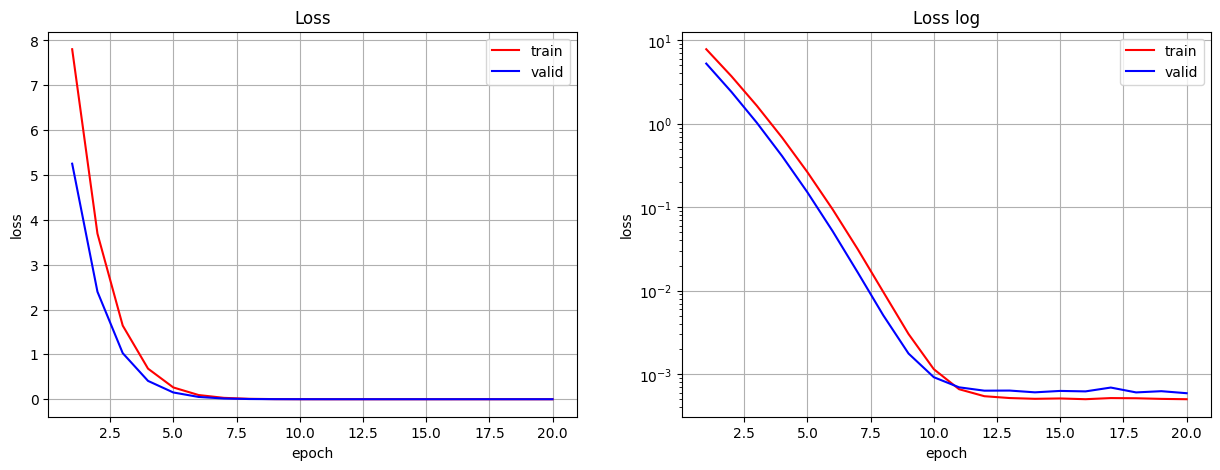

In [23]:
dnn_model = Sequential((
    Input(shape=x_train.shape[1:]),
    Flatten(),
    Dense(32, activation='relu',
          kernel_regularizer=L2(0.2)),
    Dense(y_train.shape[1], activation='softmax')
))

train_and_evaluate_model(dnn_model, x_train, y_train,
                         x_val, y_val, x_test, y_test,
                         epochs=20)

## Backtesting

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


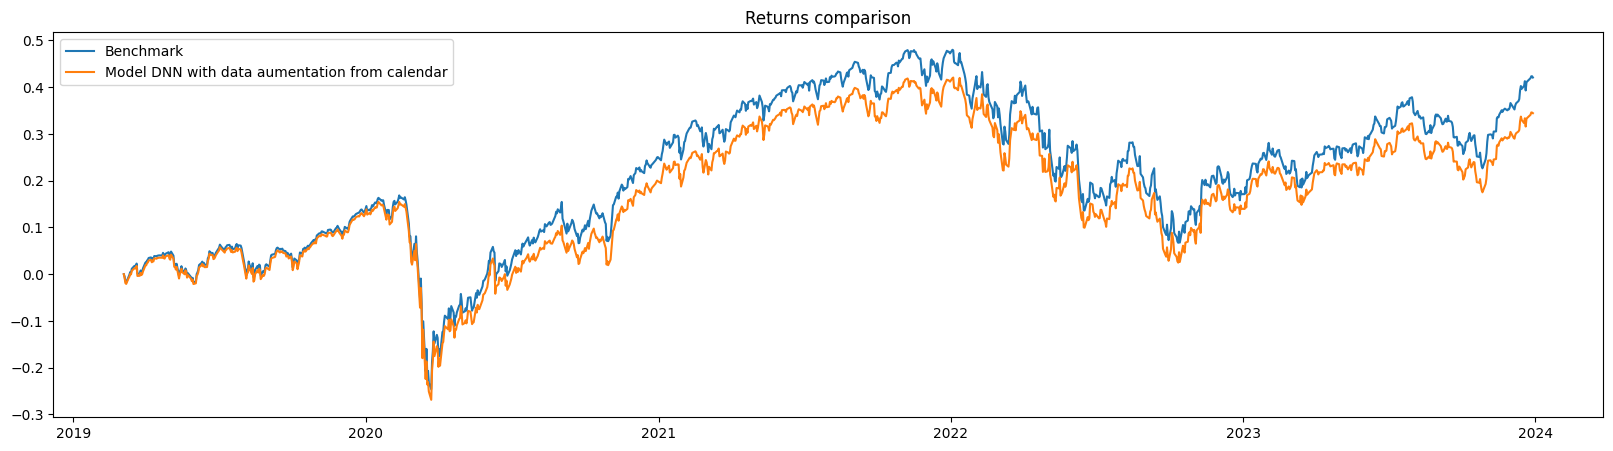

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.0768,0.2033,0.3775,0.442,-0.3548,500.0,0.2163,0.000
Model DNN with data aumentation from calendar,0.0640,0.2023,0.3165,0.368,-0.3666,499.0,0.1746,-0.578


In [24]:
models = {
    'Model DNN with data aumentation from calendar': (dnn_model, x_test),
}

df_results = run_full_backtesting(data_provider, models)
df_results

## Save trained model

In [25]:
dnn_model.save('daily_dnn_model_from_calendar.keras')